# Hi, isnt this crazy? We doin a coding competition :D

In [2]:
# Imports
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    KBinsDiscretizer,
)
from sklearn.utils import shuffle
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import VarianceThreshold

from xgboost import XGBClassifier
from xgboost import plot_importance

from tqdm import tqdm

In [3]:
# Set "global" seed
np.random.seed(42)

In [4]:
def save_df(data, location):
    """
    Specify the datframe and folder inside of "Predictions" to save the predictions
    """
    
    version = 0
    filename = f"Predictions/{location}/v{version}.csv"

    # Check if the file already exists
    while os.path.isfile(filename):
        version += 1
        filename = f"Predictions/{location}/v{version}.csv"

    data.to_csv(filename, index=False)

    return f"Data written to file: {filename}"

### train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

| Features | Description |
| -------- | ----------- |
| PassengerId | A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always. |
| HomePlanet | The planet the passenger departed from, typically their planet of permanent residence. |
| CryoSleep | Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins. |
| Cabin | The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. |
| Destination | The planet the passenger will be debarking to. |
| Age | The age of the passenger. |
| VIP | Whether the passenger has paid for special VIP service during the voyage. |
| RoomService, FoodCourt, ShoppingMall, Spa, VRDeck | Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. |
| Name | The first and last names of the passenger. |
| Transported | Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict. |

### test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

### sample_submission.csv - A submission file in the correct format.

**PassengerId** - Id for each passenger in the test set. <br>
**Transported** - The target. For each passenger, predict either True or False.

# Read data


In [5]:
train = pd.read_csv("DATA/train.csv")
test = pd.read_csv("DATA/test.csv")

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
# Reduce Memory Usage / Set correct dtypes
# reference : https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [8]:
# Actually increases mem usage a bit but we want the correct data types to work with the data
# train = reduce_memory_usage(train)
# test = reduce_memory_usage(test)

In [9]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [10]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [12]:
for col in train.columns:
    if train[col].dtype != "category":
        print(f"{col} has {len(train[col].value_counts())} different categories")

PassengerId has 8693 different categories
HomePlanet has 3 different categories
CryoSleep has 2 different categories
Cabin has 6560 different categories
Destination has 3 different categories
Age has 80 different categories
VIP has 2 different categories
RoomService has 1273 different categories
FoodCourt has 1507 different categories
ShoppingMall has 1115 different categories
Spa has 1327 different categories
VRDeck has 1306 different categories
Name has 8473 different categories
Transported has 2 different categories


In [13]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [15]:
X = train.drop(columns=["Transported"])
y = train["Transported"]

# Data Cleaning / EDA

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RoomService'}>],
       [<Axes: title={'center': 'FoodCourt'}>,
        <Axes: title={'center': 'ShoppingMall'}>],
       [<Axes: title={'center': 'Spa'}>,
        <Axes: title={'center': 'VRDeck'}>]], dtype=object)

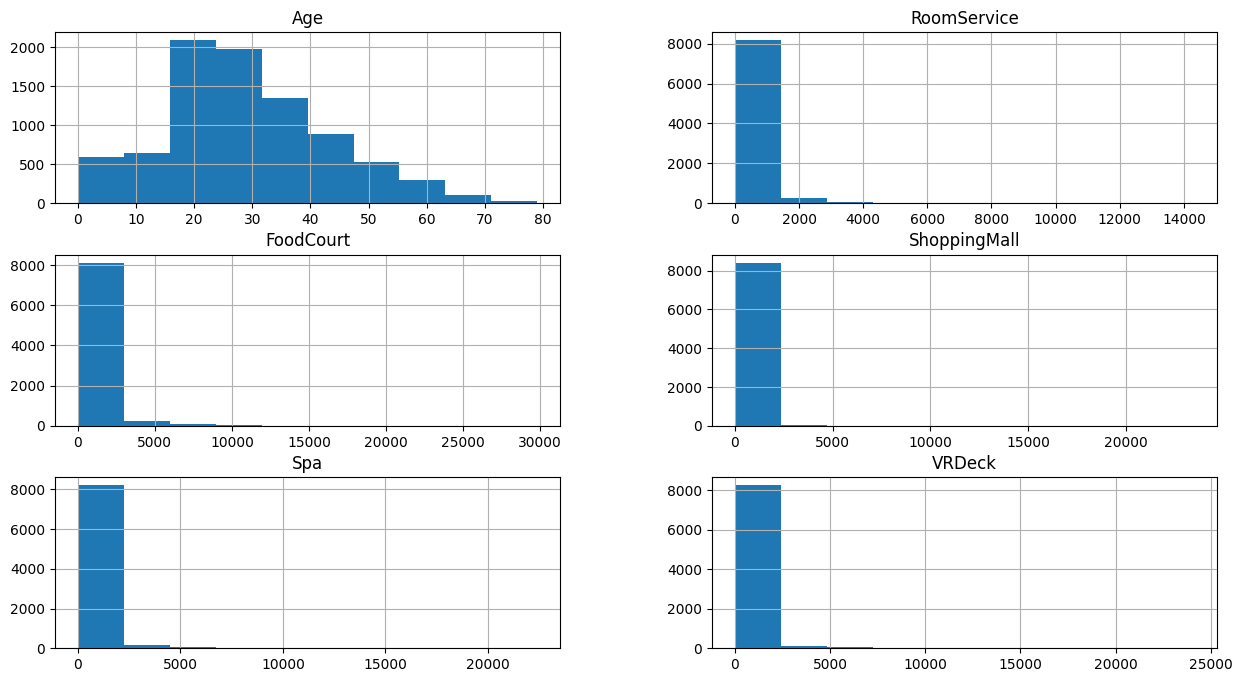

In [16]:
X.hist(figsize=(15,8))

<Axes: >

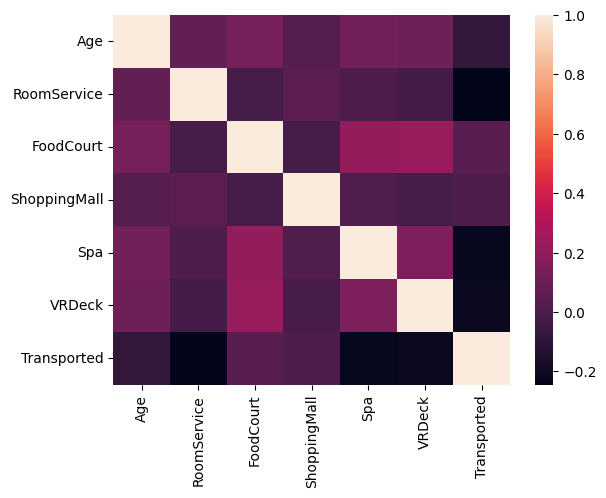

In [17]:
sns.heatmap(train.corr())

# Feature Engineering/Selection

In [18]:
def create_features(df):

    df = df.copy()

    df["Cabin_Deck"] = df["Cabin"].str.split("/").str[0]
    df["Cabin_Side"] = df["Cabin"].str.split("/").str[2]
    
    # Create Traveling Alone Feature
    df["Group"] = df["PassengerId"].str.split("_").str[0].astype(int)
    group_sizes = df.groupby("Group").size()
    df = df.merge(group_sizes.rename("GroupSize"), left_on="Group", right_index=True)
    df["TravelingAlone"] = np.where(df["GroupSize"] > 1, False, True)
    df.drop(["Group", "GroupSize"], axis=1, inplace=True)

    return df

In [19]:
X = create_features(X)
test = create_features(test)

In [20]:
X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cabin_Deck,Cabin_Side,TravelingAlone
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,P,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,S,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,S,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,S,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,S,True


In [21]:
X = X.drop(columns=["Cabin", "PassengerId", "Name"])

# Model Training

In [22]:
X["CryoSleep"] = X["CryoSleep"].astype(bool)
X["VIP"] = X["VIP"].astype(bool)

test["CryoSleep"] = test["CryoSleep"].astype(bool)
test["VIP"] = test["VIP"].astype(bool)

In [23]:
#categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
#numerical_features = X.select_dtypes(include=np.number).columns.tolist()

In [24]:
# Check data types match
test.info() == X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     4277 non-null   object 
 1   HomePlanet      4190 non-null   object 
 2   CryoSleep       4277 non-null   bool   
 3   Cabin           4177 non-null   object 
 4   Destination     4185 non-null   object 
 5   Age             4186 non-null   float64
 6   VIP             4277 non-null   bool   
 7   RoomService     4195 non-null   float64
 8   FoodCourt       4171 non-null   float64
 9   ShoppingMall    4179 non-null   float64
 10  Spa             4176 non-null   float64
 11  VRDeck          4197 non-null   float64
 12  Name            4183 non-null   object 
 13  Cabin_Deck      4177 non-null   object 
 14  Cabin_Side      4177 non-null   object 
 15  TravelingAlone  4277 non-null   bool   
dtypes: bool(3), float64(6), object(7)
memory usage: 480.3+ KB
<class 'pandas.core.

True

In [25]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Side,TravelingAlone
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P,True
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S,True


In [26]:
# X = shuffle(X)
# y = shuffle(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [27]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6954, 13), (1739, 13), (6954,), (1739,))

In [ ]:
transformer_num_pipe = Pipeline(
    [("Impute", SimpleImputer(strategy="median"))]
)

transformer_ohe_cat_pipe = Pipeline(
    [
        ("Impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(sparse_output=False)),
    ]
)

transformer_bin_pipe = Pipeline(
    [
        ("Impute", SimpleImputer(strategy="median")),
        ("ohe", KBinsDiscretizer(n_bins=5, encode="onehot", strategy="quantile")),
    ]
)

In [ ]:
transformer = ColumnTransformer(
    [
        ("Numeric", transformer_num_pipe, ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]),
        ("Categorical_OHE", transformer_ohe_cat_pipe, ["HomePlanet", "Destination", "Cabin_Deck", "Cabin_Side", "Cabin_Deck"]),
        ("Binning", transformer_bin_pipe, ["Age"]),
    ],
    remainder="passthrough",
)


## Baseline Models

### Decision Tree

In [ ]:
tree = Pipeline(
    [
        ("Preprocessing", transformer),
        ("Feature_Selection", VarianceThreshold(0.25)),
        ("Scaler", StandardScaler()),
        ("DT", DecisionTreeClassifier()),
    ]
)

In [ ]:
tree.fit(X_train, y_train)

In [ ]:
tree.score(X_val, y_val)

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=tree, X=X_val, y=y_val)

### Logistic Regression

In [ ]:
log = Pipeline(
    [
        ("Preprocessing", transformer),
        ("Scaler", StandardScaler()),
        ("Feature_Selection", VarianceThreshold(0.25)),
        ("LG", LogisticRegression()),
    ]
)

In [ ]:
log.fit(X_train, y_train)

In [ ]:
log.score(X_val, y_val)

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=log, X=X_val, y=y_val)

### Random Forest

In [ ]:
forest = Pipeline(
    [
        ("Preprocessing", transformer),
        ("Scaler", StandardScaler()),
        ("Feature_Selection", VarianceThreshold(0.25)),
        ("RF", RandomForestClassifier()),
    ]
)

In [ ]:
forest.fit(X_train, y_train)

In [ ]:
forest.score(X_val, y_val)

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=forest, X=X_val, y=y_val)

In [ ]:
forest_preds = forest.predict(test.drop(columns=["Name", "PassengerId", "Cabin"])).astype(bool)

In [ ]:
forest_results = test[["PassengerId"]]
forest_results["Transported"] = forest_preds
forest_results.head() #Shows the first few rows

In [ ]:
forest_results.dtypes

In [ ]:
save_df(data=forest_results, location="RF")

### SVM

In [ ]:
svm = Pipeline(
    [
        ("Preprocessing", transformer),
        ("Scaler", StandardScaler()),
        ("Feature_Selection", VarianceThreshold(0.25)),
        ("DT", SVC()),
    ]
)

In [ ]:
svm.fit(X_train, y_train)

In [ ]:
svm.score(X_val, y_val)

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=svm, X=X_val, y=y_val)

### XGBoost

In [ ]:
xgb = Pipeline(
    [
        ("Preprocessing", transformer),
        ("Scaler", StandardScaler()),
        ("Feature_Selection", VarianceThreshold(0.25)),
        ("XGB", XGBClassifier()),
    ]
)

In [ ]:
xgb.fit(X_train, y_train)

In [ ]:
xgb.score(X_val, y_val)

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=xgb, X=X_val, y=y_val)

In [ ]:
xgb_preds = xgb.predict(test.drop(columns=["Name", "PassengerId", "Cabin"])).astype(bool)

In [ ]:
xgb_results = test[["PassengerId"]]
xgb_results["Transported"] = xgb_preds
xgb_results.head() #Shows the first few rows

In [ ]:
xgb_results.dtypes

In [ ]:
save_df(data=xgb_results, location="XGB")

In [ ]:
# Feature importance
data = list(zip(xgb[:-1].get_feature_names_out(), abs(xgb[-1].feature_importances_)))
df_importances = pd.DataFrame(data, columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

# Plot feature importance
df_importances.plot.barh(x="Feature", y="Importance")

## Grid Search / Optimization - XGBoost

Best params (XGBoost): {'Classifier__colsample_bytree': 0.5, 'Classifier__gamma': 0, 'Classifier__learning_rate': 0.01, 'Classifier__max_depth': 6, 'Classifier__min_child_weight': 1, 'Classifier__n_estimators': 500, 'Classifier__reg_alpha': 1, 'Classifier__reg_lambda': 0.1, 'Classifier__subsample': 0.6, 'Feature_Selection__threshold': 0, 'Preprocessing__Binning__ohe__n_bins': 5, 'Preprocessing__Numeric__Impute__strategy': 'mean'}

CV Accuracy: 0.8070180864654072

Val Accuracy: 0.7889591719378953


### We proceed to add  early stopping and further improvements now

In [28]:
transformer_num_pipe = Pipeline(
    [("Impute", SimpleImputer(strategy="mean"))]
)

transformer_ohe_cat_pipe = Pipeline(
    [
        ("Impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(sparse_output=False)),
    ]
)

transformer_bin_pipe = Pipeline(
    [
        ("Impute", SimpleImputer(strategy="median")),
        ("ohe", KBinsDiscretizer(n_bins=5, encode="onehot", strategy="quantile")),
    ]
)

In [29]:
transformer = ColumnTransformer(
    [
        ("Numeric", transformer_num_pipe, ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]),
        ("Categorical_OHE", transformer_ohe_cat_pipe, ["HomePlanet", "Destination", "Cabin_Deck", "Cabin_Side", "Cabin_Deck"]),
        ("Binning", transformer_bin_pipe, ["Age"]),
    ],
    remainder="passthrough",
)

In [30]:
pipe = Pipeline(
    [
        ("Preprocessing", transformer),
        ("Scaler", StandardScaler()),
        ("Feature_Selection", VarianceThreshold(0)),
    ]
)

In [31]:
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)

In [463]:
xgb = XGBClassifier(
    colsample_bytree=0.6,
    gamma=10,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=2,
    n_estimators=100,
    #reg_lambda=1,
    #reg_alpha=1,
    subsample=0.5,
    eval_metric="rmse"
)

In [464]:
xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    early_stopping_rounds=10,
    verbose=10
)

xgb.score(X_val, y_val)

[0]	validation_0-rmse:0.48233	validation_1-rmse:0.48313
[10]	validation_0-rmse:0.39879	validation_1-rmse:0.40593
[20]	validation_0-rmse:0.37596	validation_1-rmse:0.38680
[30]	validation_0-rmse:0.36860	validation_1-rmse:0.38143
[40]	validation_0-rmse:0.36516	validation_1-rmse:0.37913
[50]	validation_0-rmse:0.36307	validation_1-rmse:0.37733
[60]	validation_0-rmse:0.36162	validation_1-rmse:0.37685
[66]	validation_0-rmse:0.36157	validation_1-rmse:0.37681


0.78205865439908

In [465]:
test_trans = test.drop(columns=["Name", "PassengerId", "Cabin"])
test_trans = pipe.transform(test_trans)
xgb_preds = xgb.predict(test_trans).astype(bool)
xgb_results = test[["PassengerId"]]
xgb_results["Transported"] = xgb_preds

In [466]:
save_df(data=xgb_results, location="XGB")

'Data written to file: Predictions/XGB/v6.csv'

## Grid Search / Optimization - Random Forest

Best params: {'Classifier__criterion': 'entropy', 'Classifier__max_depth': None, 'Classifier__max_features': 'sqrt', 'Classifier__max_leaf_nodes': None, 'Classifier__min_impurity_decrease': 0.0, 'Classifier__min_samples_leaf': 4, 'Classifier__min_samples_split': 10, 'Classifier__n_estimators': 100, 'Feature_Selection__threshold': 0, 'Preprocessing__Binning__ohe__n_bins': 10, 'Preprocessing__Numeric__Impute__strategy': 'mean'}

CV Accuracy: 0.8098946464683034

Val Accuracy: 0.7912593444508338

### Further improvements?